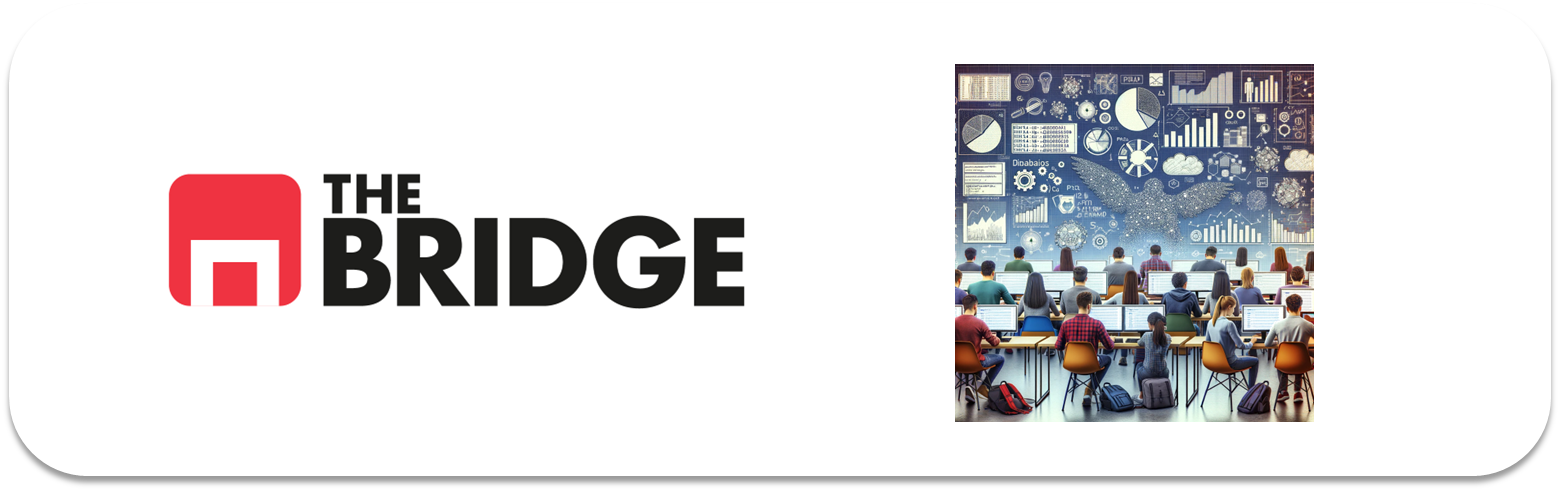

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bootcampviztools as bvt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifier, ElasticNet, Lasso
from sklearn import metrics

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 

In [2]:
df = pd.read_csv('./data/titanic.csv')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.

In [4]:
col_rep = ["alive","embark_town","class"] # Valores repetidos
columns_to_drop = ['deck'] + col_rep # Deck tiene muchos valores faltantes
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,adult_male,alone
0,0,3,male,22.0,1,0,7.2500,S,man,True,False
1,1,1,female,38.0,1,0,71.2833,C,woman,False,False
2,1,3,female,26.0,0,0,7.9250,S,woman,False,True
3,1,1,female,35.0,1,0,53.1000,S,woman,False,False
4,0,3,male,35.0,0,0,8.0500,S,man,True,True


In [5]:
for col in df.select_dtypes(include=['object', 'string']):
    df[col] = df[col].str.strip()

In [6]:
df.isna().sum()

survived        0
pclass          0
sex             0
age           177
sibsp           0
parch           0
fare            0
embarked        2
who             0
adult_male      0
alone           0
dtype: int64

3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.

<Axes: xlabel='survived', ylabel='count'>

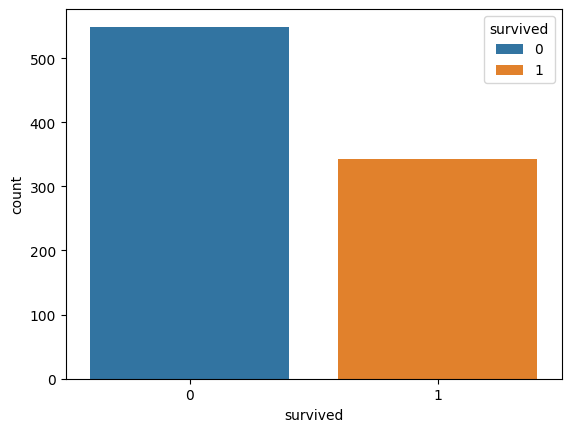

In [7]:
target = df["survived"]
sns.countplot(df, x='survived', hue='survived')


4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.

In [8]:
# Imputo los valores nulos por la moda de la columna ya que, si no lo hago, no se podrá hacer el split de los datos
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)

train_set, test_set = train_test_split(df, test_size= 0.2, stratify= df["embarked"], random_state= 42)

C:\Users\rafae\AppData\Local\Temp\ipykernel_3156\2925375991.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)


In [9]:
train_set.embarked.value_counts(normalize=True)

embarked
S    0.724719
C    0.188202
Q    0.087079
Name: proportion, dtype: float64

In [10]:
test_set.embarked.value_counts(normalize=True)

embarked
S    0.726257
C    0.189944
Q    0.083799
Name: proportion, dtype: float64

5. Construye las parejas X,y de train y test.

6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.

In [11]:
# Imputar valores nulos en la columna "age" con la edad media de cada grupo para el TRAIN SET

es_hombre_train = train_set.who == "man"
es_mujer_train = train_set.who == "woman"
es_child_train = train_set.who == "child"

mean_man_train = train_set[es_hombre_train]["age"].mean()
mean_woman_train = train_set[es_mujer_train]["age"].mean()
mean_child_train = train_set[es_child_train]["age"].mean()

es_nulo_train = train_set.age.isna()

train_set.loc[es_hombre_train & es_nulo_train, "age"] = mean_man_train
train_set.loc[es_mujer_train & es_nulo_train, "age"] = mean_woman_train
train_set.loc[es_child_train & es_nulo_train, "age"] = mean_child_train

# Imputar valores nulos en la columna "age" con la edad media de cada grupo para el TEST SET

es_hombre_test = test_set.who == "man"
es_mujer_test = test_set.who == "woman"
es_child_test = test_set.who == "child"

mean_man_test = test_set[es_hombre_test]["age"].mean()
mean_woman_test = test_set[es_mujer_test]["age"].mean()
mean_child_test = test_set[es_child_test]["age"].mean()

es_nulo_test = test_set.age.isna()

test_set.loc[es_hombre_test & es_nulo_test, "age"] = mean_man_test
test_set.loc[es_mujer_test & es_nulo_test, "age"] = mean_woman_test
test_set.loc[es_child_test & es_nulo_test, "age"] = mean_child_test

In [12]:
test_set.isna().sum()

survived      0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
who           0
adult_male    0
alone         0
dtype: int64

In [13]:
# Crear columna "family" que sea la suma de "sibsp" y "parch" y eliminar estas dos columnas del TRAIN SET 
train_set["family"] = train_set["sibsp"] + train_set["parch"]
train_set.drop(columns=["sibsp", "parch"], inplace=True)

# Crear columna "family" que sea la suma de "sibsp" y "parch" y eliminar estas dos columnas del TEST  SET 
test_set["family"] = test_set["sibsp"] + test_set["parch"]
test_set.drop(columns=["sibsp", "parch"], inplace=True)

In [14]:
print(test_set.duplicated().sum(), "Valores duplicados en el train set")
test_set.drop_duplicates(inplace=True)
print((test_set.duplicated().sum()), "duplicados en el train set","\n",(test_set.isna().sum().sum()), "valores nulos en el train set ")

5 Valores duplicados en el train set
0 duplicados en el train set 
 0 valores nulos en el train set 


In [15]:
print(train_set.duplicated().sum(), "Valores duplicados en el test set")
train_set.drop_duplicates(inplace=True)
print((train_set.duplicated().sum()), "duplicados en el test set","\n",(train_set.isna().sum().sum()), "valores nulos en el test set ")

89 Valores duplicados en el test set
0 duplicados en el test set 
 0 valores nulos en el test set 


In [16]:
X_train = train_set.drop(columns=['survived'])
y_train = train_set['survived']
X_test = test_set.drop(columns=['survived'])
y_test = test_set['survived']

7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 838 to 571
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      623 non-null    int64  
 1   sex         623 non-null    object 
 2   age         623 non-null    float64
 3   fare        623 non-null    float64
 4   embarked    623 non-null    object 
 5   who         623 non-null    object 
 6   adult_male  623 non-null    bool   
 7   alone       623 non-null    bool   
 8   family      623 non-null    int64  
dtypes: bool(2), float64(2), int64(2), object(3)
memory usage: 40.2+ KB


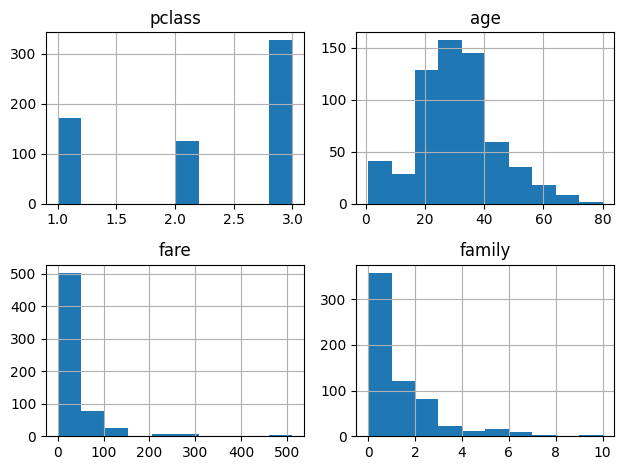

In [18]:
X_train.hist()
plt.tight_layout()

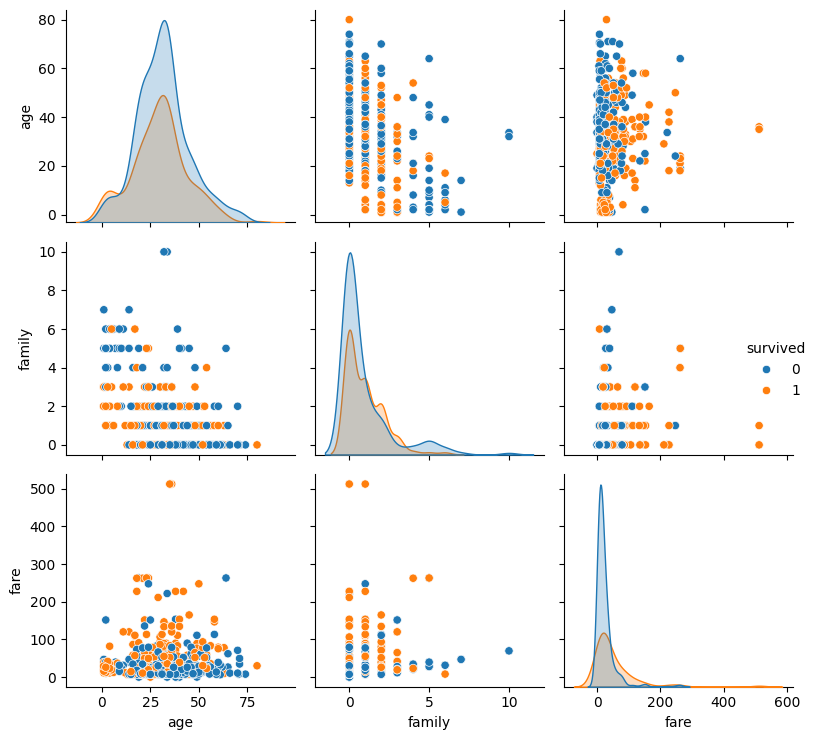

In [19]:
feat_num = ['age', 'family', 'fare']

# Combinar X_train y y_train para usar en un pairplot

X_train_with_target = X_train.copy()
X_train_with_target['survived'] = y_train
sns.pairplot(X_train_with_target[feat_num + ['survived']], hue='survived')
plt.tight_layout()
plt.show()


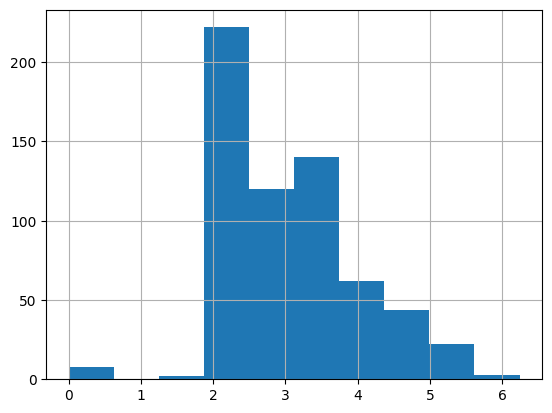

In [20]:
train_set["fare"].apply(np.log1p).hist()
plt.show()


In [21]:
feat_cat = ['pclass','sex','who','adult_male','embarked','alone']


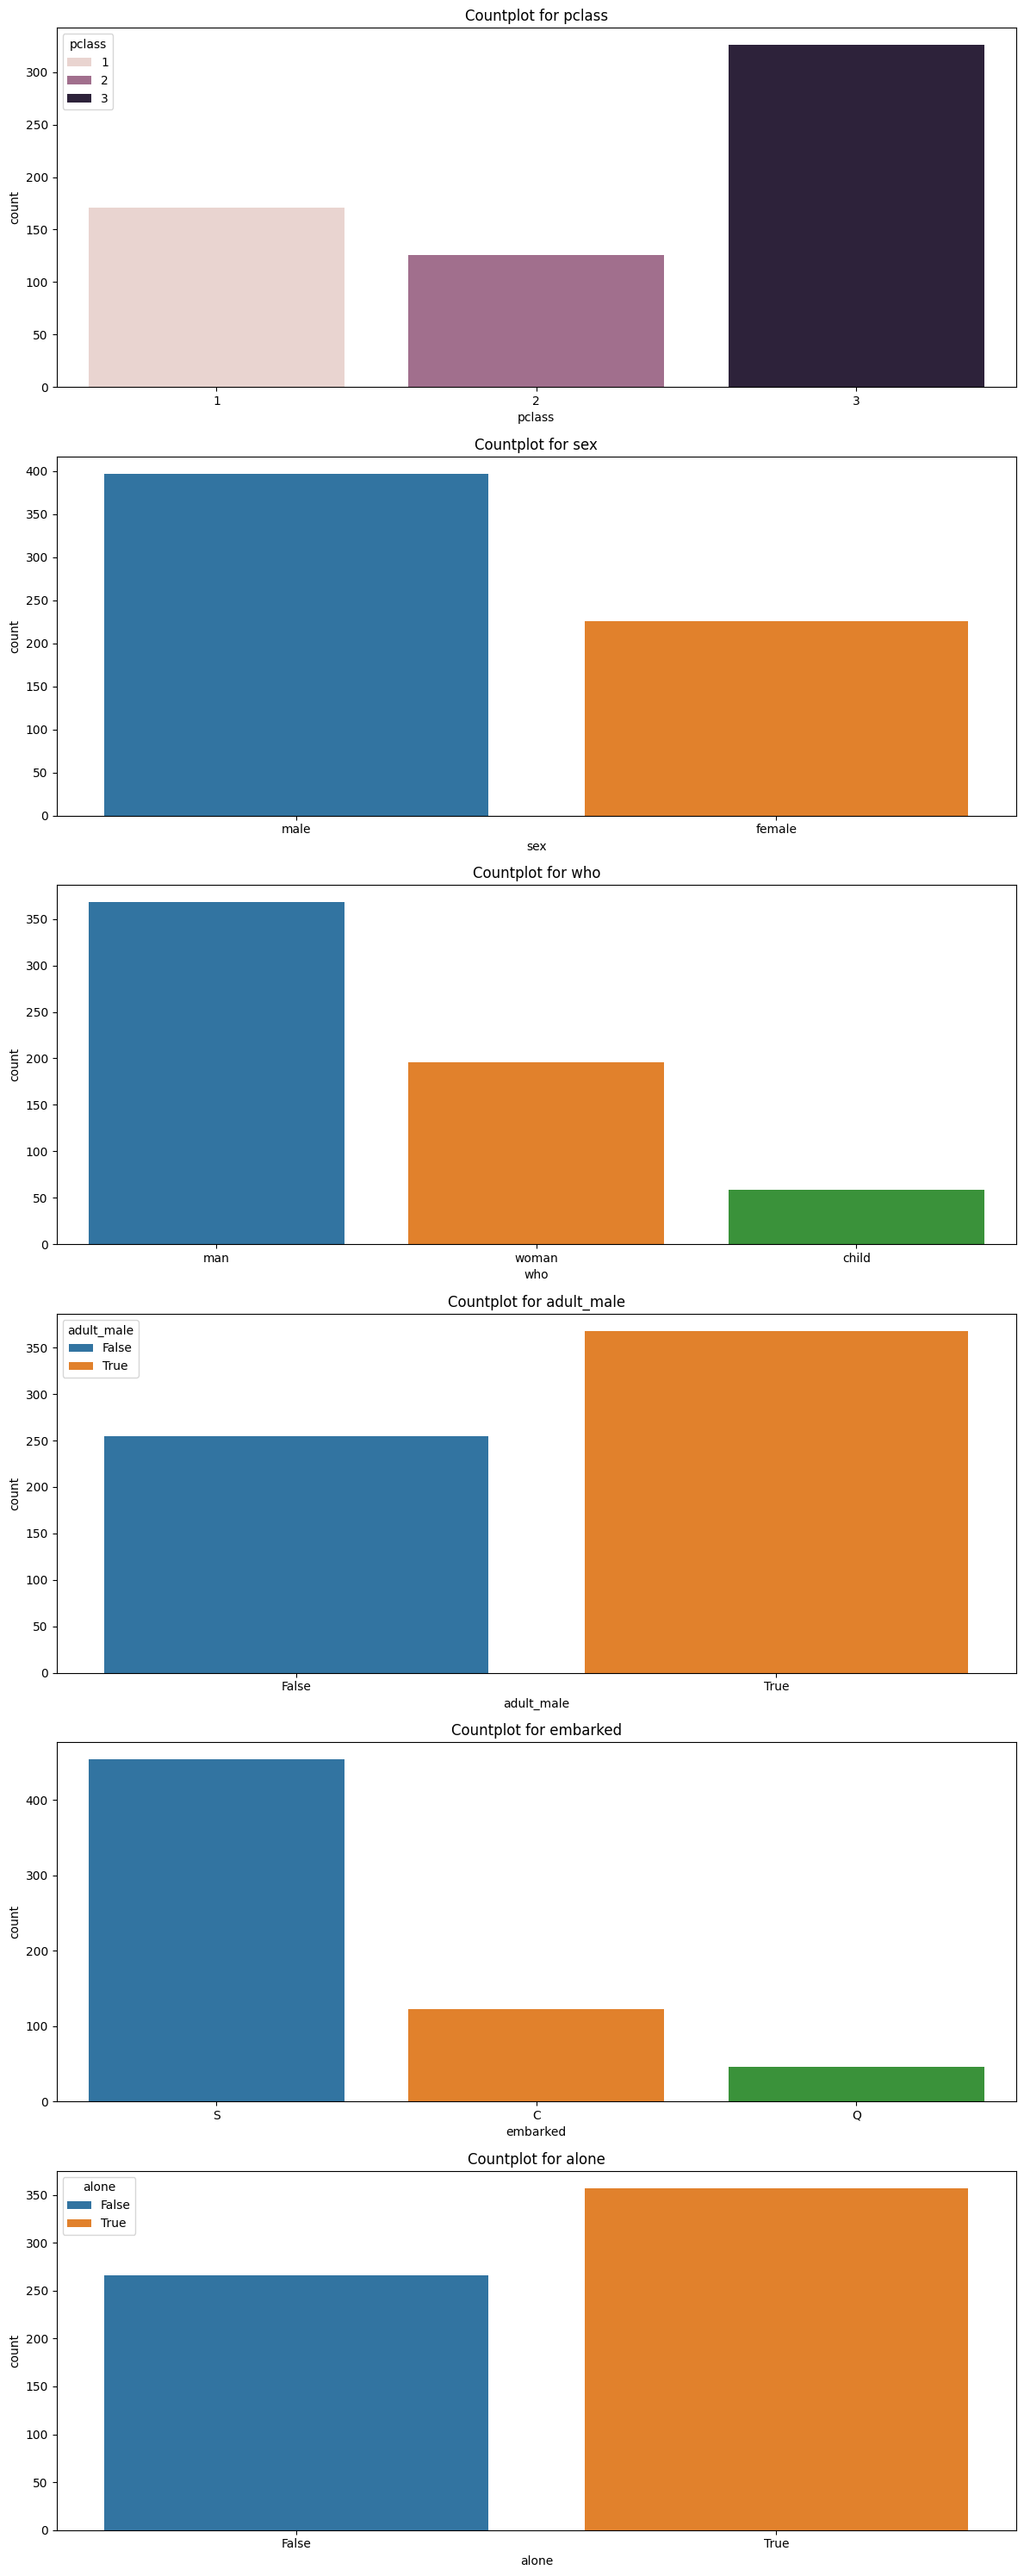

In [22]:
fig, ax = plt.subplots(len(feat_cat), 1, figsize=(12, 5 * len(feat_cat)))
for i, col in enumerate(feat_cat):
    sns.countplot(X_train, x=col, hue=col, ax=ax[i])
    ax[i].set_title(f"Countplot for {col}")

plt.tight_layout()
plt.show()

In [23]:
X_train.columns.to_list()

['pclass',
 'sex',
 'age',
 'fare',
 'embarked',
 'who',
 'adult_male',
 'alone',
 'family']

In [24]:
X_train.drop('adult_male', axis=1, inplace=True)
X_test.drop('adult_male', axis=1, inplace=True)

In [25]:
X_train.columns.to_list()

['pclass', 'sex', 'age', 'fare', 'embarked', 'who', 'alone', 'family']

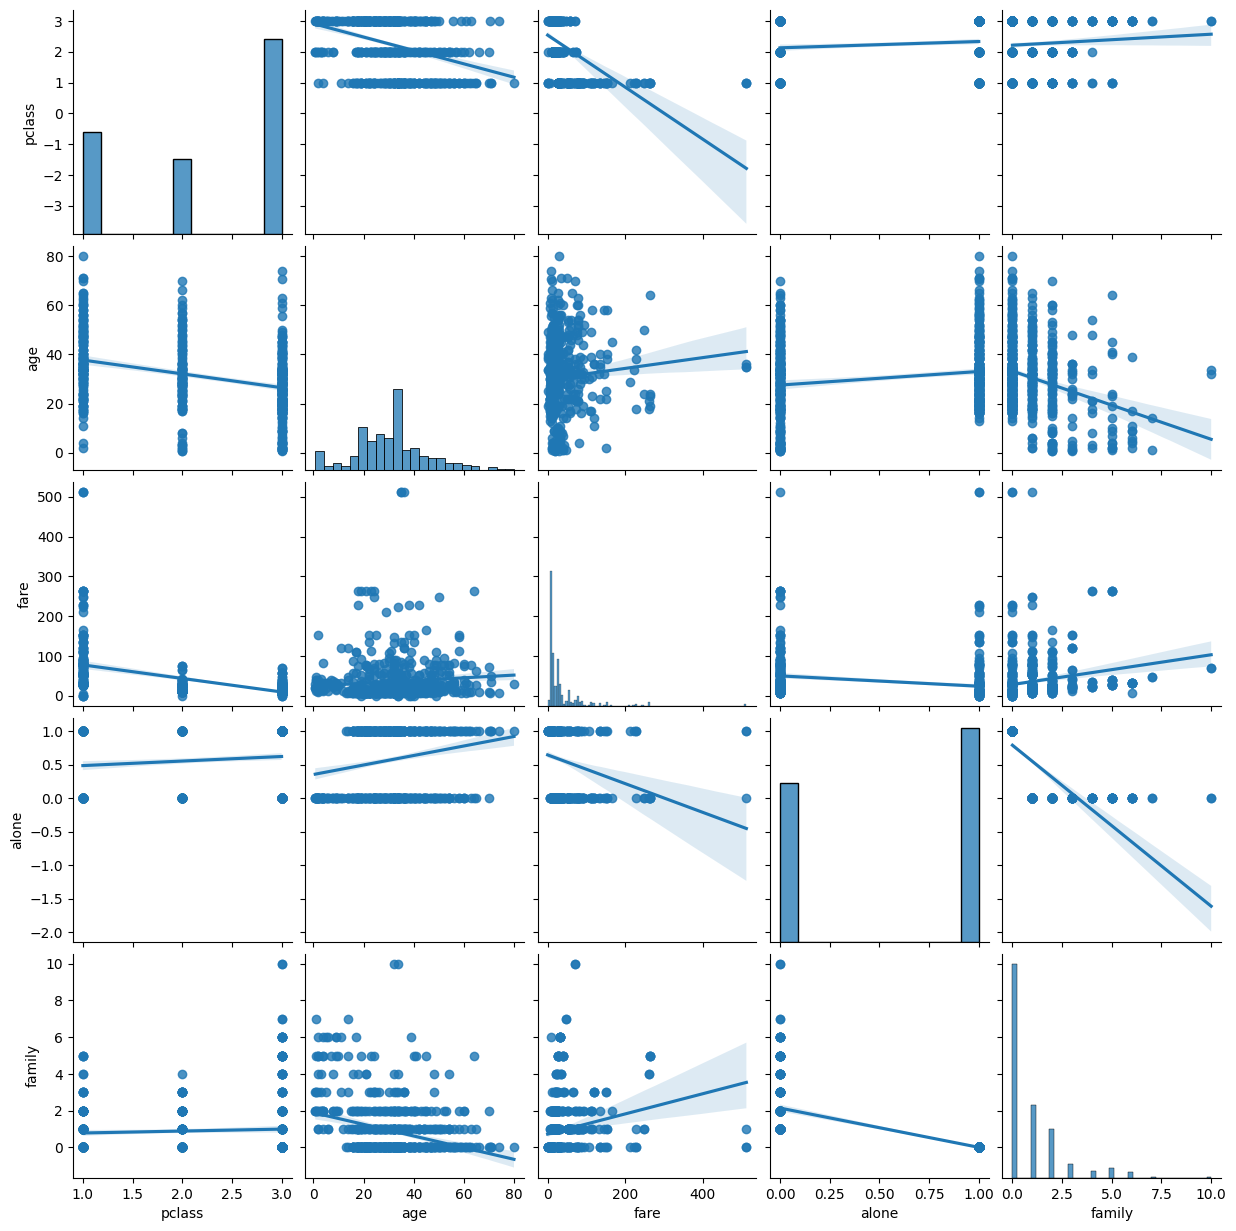

In [26]:
sns.pairplot(X_train,
             kind='reg')

In [27]:
abs(X_train.corrwith(y_train, numeric_only=True)).sort_values(ascending=False)

pclass    0.324514
fare      0.256161
alone     0.183412
age       0.067490
family    0.023512
dtype: float64

8. Trata las variables para que funcionen lo mejor posible en el modelo.

In [28]:
# One hot encoding para las columnas categóricas "who" y "embarked"
dummy_cols = ['who','embarked']
X_train = pd.get_dummies(X_train, columns=dummy_cols)

X_test = pd.get_dummies(X_test, columns=dummy_cols)


In [29]:
# Transformar columnas "alone" y "sex" en columnas binarias
X_train['alone'] = X_train['alone'].astype(int)
X_test['alone'] = X_test['alone'].astype(int)

X_train['sex'] = X_train['sex'].apply(lambda x: 1 if x == 'male' else 0)
X_test['sex'] = X_test['sex'].apply(lambda x: 1 if x == 'male' else 0)

In [30]:
X_train.head()

,pclass,sex,age,fare,alone,family,who_child,who_man,who_woman,embarked_C,embarked_Q,embarked_S
838,3,1,32.0,56.4958,1,0,False,True,False,False,False,True
621,1,1,42.0,52.5542,0,1,False,True,False,False,False,True
282,3,1,16.0,9.5000,1,0,False,True,False,False,False,True
275,1,0,63.0,77.9583,0,1,False,False,True,False,False,True
217,2,1,42.0,27.0000,0,1,False,True,False,False,False,True


In [31]:
# Identificar las columnas booleanas
bool_cols_train = X_train.select_dtypes(include=['bool']).columns
bool_cols_test = X_test.select_dtypes(include=['bool']).columns

# Convertirlas a int
X_train[bool_cols_train] = X_train[bool_cols_train].astype(int)
X_test[bool_cols_test] = X_test[bool_cols_test].astype(int)


In [32]:
X_train.head()

,pclass,sex,age,fare,alone,family,who_child,who_man,who_woman,embarked_C,embarked_Q,embarked_S
838,3,1,32.0,56.4958,1,0,0,1,0,0,0,1
621,1,1,42.0,52.5542,0,1,0,1,0,0,0,1
282,3,1,16.0,9.5000,1,0,0,1,0,0,0,1
275,1,0,63.0,77.9583,0,1,0,0,1,0,0,1
217,2,1,42.0,27.0000,0,1,0,1,0,0,0,1


In [33]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

9. Construye un modelo de regresión logística.

In [34]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.

In [35]:
intercept = log_reg.intercept_
coefs = log_reg.coef_

features = pd.DataFrame(coefs.T, X_train.columns, columns=['coefficient']).sort_values('coefficient', ascending=False)
features

,coefficient
who_woman,0.577007
who_child,0.333892
fare,0.189817
embarked_C,0.079712
embarked_Q,-0.005091
sex,-0.006347
embarked_S,-0.068371
alone,-0.231211
age,-0.234836
pclass,-0.724941


11. Procesa el dataset de Test para que puedas usarlo en la evaluación 

- Ya lo hice a medida que iba haciendo los de Train

12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.

In [36]:
ridgeR = Ridge(alpha = 10.0) # L2
ridgeR.fit(X_train_scaled, y_train)

Ridge(alpha=10.0)

In [37]:
# Parámetros para Ridge
ridge_params = {'alpha': np.linspace(0.1, 10, 100)}
ridge_search = GridSearchCV(Ridge(), ridge_params, scoring='neg_mean_squared_error', cv=5)
ridge_search.fit(X_train_scaled, y_train)
print("Mejor alpha para Ridge:", ridge_search.best_params_)

Mejor alpha para Ridge: {'alpha': np.float64(10.0)}


In [38]:
lassoR = Lasso(alpha = 0.01) # L1
lassoR.fit(X_train_scaled,y_train)

Lasso(alpha=0.01)

In [39]:
# Parámetros para Lasso
lasso_params = {'alpha': np.linspace(0.01, 0.1, 100)}
lasso_search = GridSearchCV(Lasso(), lasso_params, scoring='neg_mean_squared_error', cv=5)
lasso_search.fit(X_train_scaled, y_train)
print("Mejor alpha para Lasso:", lasso_search.best_params_)

Mejor alpha para Lasso: {'alpha': np.float64(0.01)}


In [40]:
elastic_net = ElasticNet(alpha = 0.0030204081632653063, l1_ratio = 0.5353061224489796) # L1 & L2
elastic_net.fit(X_train_scaled,y_train)

ElasticNet(alpha=0.0030204081632653063, l1_ratio=0.5353061224489796)

In [41]:
# Parámetros para ElasticNet
elastic_params = {
    'alpha': np.linspace(0.001, 0.1, 50),
    'l1_ratio': np.linspace(0.01, 1, 50)
}
elastic_search = GridSearchCV(ElasticNet(max_iter=10000), elastic_params, scoring='neg_mean_squared_error', cv=5)
elastic_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000),
             param_grid={'alpha': array([0.001     , 0.00302041, 0.00504082, 0.00706122, 0.00908163,
       0.01110204, 0.01312245, 0.01514286, 0.01716327, 0.01918367,
       0.02120408, 0.02322449, 0.0252449 , 0.02726531, 0.02928571,
       0.03130612, 0.03332653, 0.03534694, 0.03736735, 0.03938776,
       0.04140816, 0.04342857, 0.04544898, 0.04746939, 0.0494898 ,...
       0.41408163, 0.43428571, 0.4544898 , 0.47469388, 0.49489796,
       0.51510204, 0.53530612, 0.5555102 , 0.57571429, 0.59591837,
       0.61612245, 0.63632653, 0.65653061, 0.67673469, 0.69693878,
       0.71714286, 0.73734694, 0.75755102, 0.7777551 , 0.79795918,
       0.81816327, 0.83836735, 0.85857143, 0.87877551, 0.89897959,
       0.91918367, 0.93938776, 0.95959184, 0.97979592, 1.        ])},
             scoring='neg_mean_squared_error')

In [42]:
# Lista de modelos y nombres
models = [
    ("Sin regularizar", log_reg),
    ("Ridge", ridgeR),
    ("Lasso", lassoR),
    ("Elastic Net", elastic_net)
]

# Lista para almacenar resultados
results = []

# Evaluar modelos en train y test
for dataset, X, y in [("Train", X_train_scaled, y_train), ("Test", X_test_scaled, y_test)]:
    for name, model in models:
        mse = metrics.mean_squared_error(y, model.predict(X))
        rmse = np.sqrt(mse)
        r2 = model.score(X, y)
        
        # Extraer los valores de alpha y l1_ratio dinámicamente
        alpha = getattr(model, "alpha", None)  # Obtener alpha si existe
        l1_ratio = getattr(model, "l1_ratio", None) if name == "Elastic Net" else None  # l1_ratio solo para Elastic Net

        # Agregar resultados a la lista
        results.append({
            "Dataset": dataset,
            "Modelo": name,
            "Alpha": alpha,
            "L1 Ratio": l1_ratio,  # Será None para modelos que no tienen este parámetro
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2
        })

# Convertir los resultados en un DataFrame
results_df = pd.DataFrame(results)

# Mostrar el DataFrame
results_df

,Dataset,Modelo,Alpha,L1 Ratio,MSE,RMSE,R2
0,Train,Sin regularizar,NaN,NaN,0.197432,0.444333,0.802568
1,Train,Ridge,10.00000,NaN,0.147065,0.383491,0.387064
2,Train,Lasso,0.01000,NaN,0.148116,0.384858,0.382684
3,Train,Elastic Net,0.00302,0.535306,0.147050,0.383470,0.387129
4,Test,Sin regularizar,NaN,NaN,0.160920,0.401148,0.839080
5,Test,Ridge,10.00000,NaN,0.123657,0.351649,0.497335
6,Test,Lasso,0.01000,NaN,0.126587,0.355790,0.485427
7,Test,Elastic Net,0.00302,0.535306,0.123762,0.351799,0.496909


In [43]:
train_pred = log_reg.predict(X_train_scaled) # Predicciones
train_pred_proba = log_reg.predict_proba(X_train_scaled)[:,1] # Probabilidad de que sea de la clase 1
report = classification_report(y_train, train_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       374
           1       0.78      0.71      0.74       249

    accuracy                           0.80       623
   macro avg       0.80      0.79      0.79       623
weighted avg       0.80      0.80      0.80       623



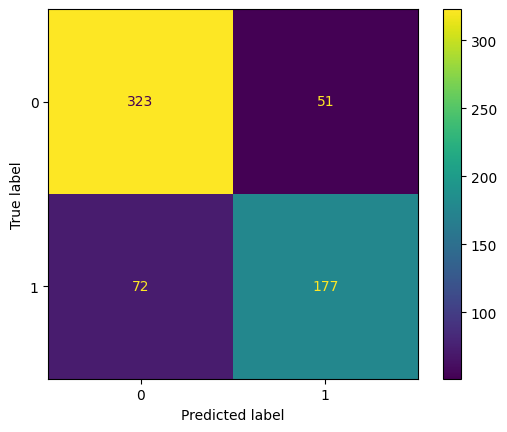

In [44]:
ConfusionMatrixDisplay(confusion_matrix(y_train, train_pred)).plot()
plt.show()

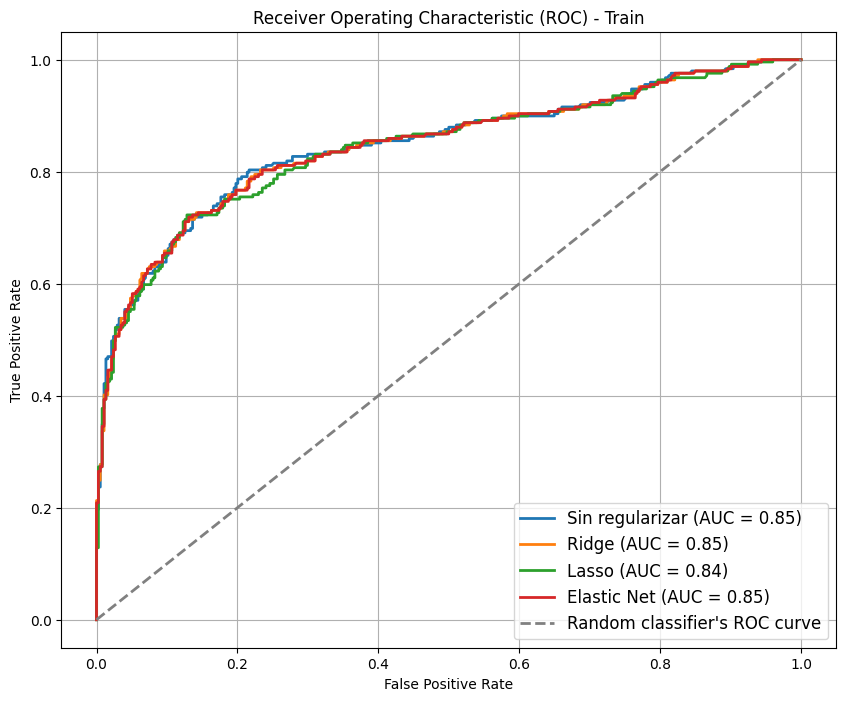

In [45]:
# Entrenar los modelos con regularización
log_reg = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_scaled, y_train)
ridge = RidgeClassifier(alpha=4.5).fit(X_train_scaled, y_train)
lasso = Lasso(alpha=0.01).fit(X_train_scaled, y_train)
elastic_net = ElasticNet(alpha=0.0030204081632653063, l1_ratio=0.5353061224489796).fit(X_train_scaled, y_train)

# Lista de modelos
models = [
    ("Sin regularizar", log_reg),
    ("Ridge", ridge),
    ("Lasso", lasso),
    ("Elastic Net", elastic_net)
]

# Dibujar curvas ROC
plt.figure(figsize=(10, 8))
for name, model in models:
    # Obtener probabilidades de clase positiva
    if name == "Ridge":
        y_train_proba = model.decision_function(X_train_scaled)  # Ridge no tiene predict_proba
    elif name in ["Lasso", "Elastic Net"]:
        y_train_proba = model.predict(X_train_scaled)  # Probabilidades equivalentes para regresión
    else:
        y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
    
    # Calcular los valores para la curva ROC
    fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)
    roc_auc = auc(fpr, tpr)
    
    # Dibujar la curva ROC
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Curva aleatoria
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label="Random classifier's ROC curve")

# Personalización del gráfico
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Train')
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()


In [46]:
test_pred = log_reg.predict(X_test_scaled) # Predicciones
test_pred_proba = log_reg.predict_proba(X_test_scaled)[:,1] # Probabilidad de que sea de la clase 1
report = classification_report(y_test, test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        98
           1       0.82      0.80      0.81        76

    accuracy                           0.84       174
   macro avg       0.84      0.83      0.84       174
weighted avg       0.84      0.84      0.84       174



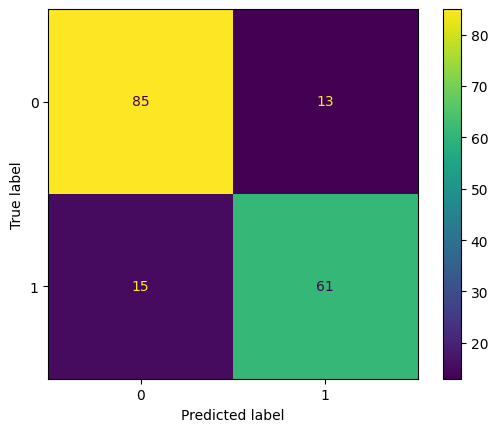

In [47]:
ConfusionMatrixDisplay(confusion_matrix(y_test, test_pred)).plot()
plt.show()

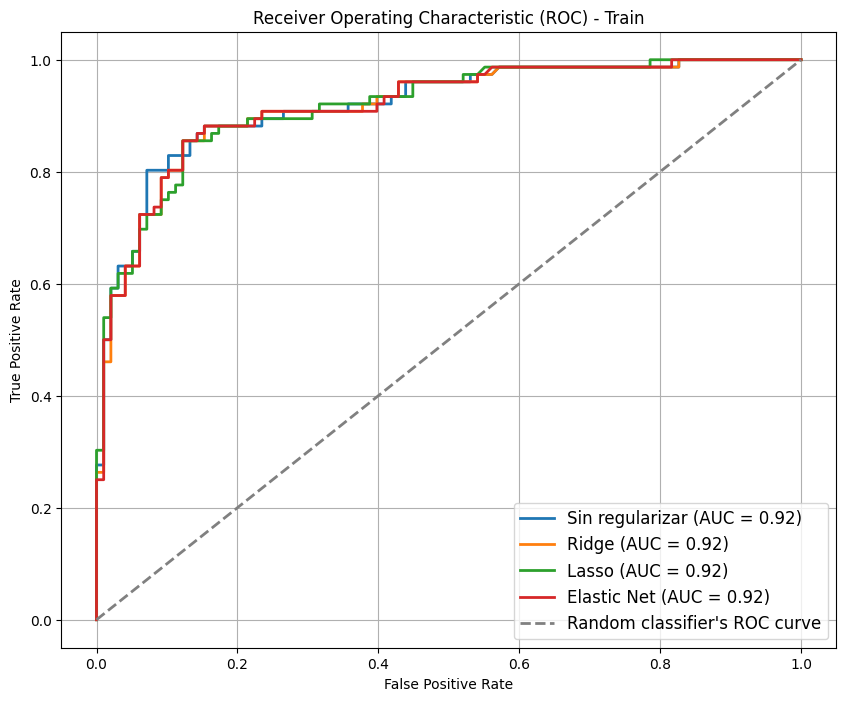

In [48]:
# Entrenar los modelos con regularización
log_reg = LogisticRegression(max_iter=1000, random_state=42).fit(X_test_scaled, y_test)
ridge = RidgeClassifier(alpha=4.5).fit(X_test_scaled, y_test)
lasso = Lasso(alpha=0.01).fit(X_test_scaled, y_test)
elastic_net = ElasticNet(alpha=0.0030204081632653063, l1_ratio=0.5353061224489796).fit(X_test_scaled, y_test)

# Lista de modelos
models = [
    ("Sin regularizar", log_reg),
    ("Ridge", ridge),
    ("Lasso", lasso),
    ("Elastic Net", elastic_net)
]

# Dibujar curvas ROC
plt.figure(figsize=(10, 8))
for name, model in models:
    # Obtener probabilidades de clase positiva
    if name == "Ridge":
        y_test_proba = model.decision_function(X_test_scaled)  # Ridge no tiene predict_proba
    elif name in ["Lasso", "Elastic Net"]:
        y_test_proba = model.predict(X_test_scaled)  # Probabilidades equivalentes para regresión
    else:
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calcular los valores para la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    # Dibujar la curva ROC
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Curva aleatoria
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label="Random classifier's ROC curve")

# Personalización del gráfico
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Train')
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

,coefs
pclass,-1.490697
sex,-0.404284
age,-0.533456
fare,-0.380956
alone,-0.219438
family,-0.482897
who_child,0.352707
who_man,-0.805342
who_woman,0.630369
embarked_C,0.149994


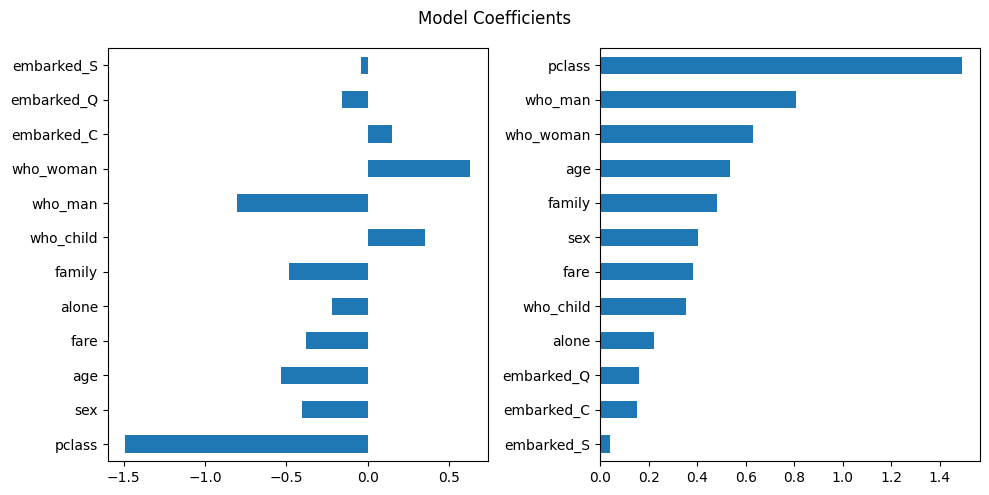

In [49]:
def show_coefs(model, figsize=(10, 5)):
    df_coef = pd.DataFrame(model.coef_[0], index=X_train.columns, columns=["coefs"])

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    df_coef.plot(kind="barh", ax=ax[0], legend=False)
    df_coef.abs().sort_values(by="coefs").plot(kind="barh", ax=ax[1], legend=False)
    fig.suptitle("Model Coefficients")

    fig.tight_layout()

    return df_coef

show_coefs(log_reg, figsize=(10, 5))

13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.

14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  

In [50]:
X_test2 = X_test.copy()
X_test2['survived'] = y_test.copy()
X_train2 = X_train.copy()
X_train2['survived'] = y_train.copy()

y_train2 = X_train['pclass']
y_test2 = X_test['pclass']

X_train2.drop('pclass', axis=1, inplace=True)
X_test2.drop('pclass', axis=1, inplace=True)

In [51]:
X_train2_scaled = scaler.fit_transform(X_train2)

X_test2_scaled = scaler.transform(X_test2)

In [52]:
log_reg2 = LogisticRegression(max_iter=10000)
log_reg2.fit(X_train2_scaled, y_train2)

LogisticRegression(max_iter=10000)

In [53]:
y_pred_train2 = log_reg2.predict(X_train2_scaled)
y_pred_test2 = log_reg2.predict(X_test2_scaled)

In [54]:
print(classification_report(y_train2, y_pred_train2))

              precision    recall  f1-score   support

           1       0.90      0.94      0.92       171
           2       0.80      0.33      0.46       126
           3       0.79      0.96      0.87       326

    accuracy                           0.83       623
   macro avg       0.83      0.74      0.75       623
weighted avg       0.82      0.83      0.80       623



In [55]:
print(classification_report(y_test2, y_pred_test2))

              precision    recall  f1-score   support

           1       0.95      0.95      0.95        41
           2       0.85      0.39      0.53        44
           3       0.77      0.98      0.86        89

    accuracy                           0.82       174
   macro avg       0.86      0.77      0.78       174
weighted avg       0.83      0.82      0.80       174

